# Аугментация

In [1]:
import albumentations as alb
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
size_img = (300, 300)
count_aug = 50
count_images = 4

In [ ]:
def gen_aug(index, sub_index):
    img = cv2.imread(f'input\img\image{index}.png')
    mask = cv2.imread(f'input\mask\mask{index}.png')
    
    # Создание объекта аугментации
    transform = alb.Compose([
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Affine(translate_percent={"x": 0.1, "y": 0.1}, rotate=(-45, 45), scale=(0.8, 1.2), p=1.0),
        alb.RandomScale(scale_limit=0.1, p=0.5), 
        alb.RandomCrop(height=size_img[0], width=size_img[1], p=0.5), 
        alb.RandomBrightnessContrast(p=0.4),
        alb.Blur(blur_limit=3, p=0.3),
    ])

    # Применение аугментации к изображению
    augmented_i = transform(image=img, mask=mask)
    # augmented_m = transform(image=mask)
    
    # Получение аугментированного изображения
    augmented_image = augmented_i['image']
    augmented_mask = augmented_i['mask']
    
    
    resized_image = cv2.resize(augmented_image, size_img)
    resized_mask = cv2.resize(augmented_mask, size_img)

    # Сохранение аугментированного изображения
    cv2.imwrite(f'augment/img/augmented_image_{index}_{sub_index}.jpg', resized_image)
    cv2.imwrite(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', resized_mask)

In [4]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [5]:
for i in range(count_images):
    for num in range(count_aug):
        gen_aug(i, num)

# Машиночитаемый вид

In [6]:
import numpy as np

In [7]:
def get_machine_img(index, sub_index):    
    img = cv2.imread(f'augment/img/augmented_image_{index}_{sub_index}.jpg')
    mask = cv2.imread(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', cv2.IMREAD_GRAYSCALE)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, size_img)
    
    norm_img = img / 255.0
    # mask = cv2.resize(mask, size_img)
    norm_mask = (mask > 0).astype(np.float32) # бинаризация
    norm_mask = norm_mask.reshape(size_img[0], size_img[1], 1)
    return (norm_img, norm_mask)
    

In [8]:
mass_img = []
mass_mask = [] 
for i in range(count_images):
    for num in range(count_aug):
        img, mask = get_machine_img(i, num)
        # print(i, num, img.shape, mask.shape)
        mass_img.append(img), mass_mask.append(mask)
mass_img = np.array(mass_img)
mass_mask = np.array(mass_mask) 

# Создание модели

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
def plot_hist(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности (accur)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # График точности (prec)
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision during training')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.show()


## Полносвязная нейронная сеть

1. **Полносвязаня нейронная сеть** - Базовая многослойная нейронка.
Между каждым нейроном между двумя ближайшими слоями есть связь, обладающая каким-то весом.
У каждого слоя есть *"функция активации"* - функция, взаимодействующая со значением.
Тренировка происходит с помощью градиентного спуска.

In [11]:
from tensorflow import keras

In [12]:
mass_img[0].shape, mass_mask[0].shape

((300, 300, 3), (300, 300, 1))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_t, x_v, y_t, y_v = train_test_split(mass_img, mass_mask, test_size=0.25, random_state=42)

In [15]:
x_t.shape

(150, 300, 300, 3)

In [16]:
# Создаем модель
model = keras.Sequential([
    # keras.layers.Input(shape=(x_t[0].shape)),
    keras.layers.Flatten(input_shape=(size_img[0], size_img[1], 3)),
    keras.layers.Dense(size_img[0] * 4, activation='relu'),
    keras.layers.Dense(size_img[0] * 2, activation='relu'),
    keras.layers.Dense(size_img[0] * size_img[1], activation='sigmoid'),
    keras.layers.Reshape((size_img[0], size_img[1], 1))
])

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

In [18]:
# Обучаем модель
hst = model.fit(x=x_t, y=y_t, validation_data=(x_v, y_v), epochs=15, batch_size=35)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.5331 - loss: 0.7662 - precision: 0.5166 - val_accuracy: 0.5440 - val_loss: 0.7165 - val_precision: 0.5867
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5920 - loss: 0.6814 - precision: 0.5794 - val_accuracy: 0.6233 - val_loss: 0.7238 - val_precision: 0.6583
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6283 - loss: 0.6801 - precision: 0.6281 - val_accuracy: 0.6271 - val_loss: 0.6575 - val_precision: 0.6710
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6804 - loss: 0.5930 - precision: 0.6593 - val_accuracy: 0.6810 - val_loss: 0.5851 - val_precision: 0.7180
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7294 - loss: 0.5258 - precision: 0.7164 - val_accuracy: 0.7126 - val_loss: 0.5610 - val_precision: 0.7315
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7473 - loss: 0.4919 - precision: 0.7364 - val_accuracy: 0.7352 - val_loss: 0.5358 - val_precision

In [19]:
# model.predict(x_v)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


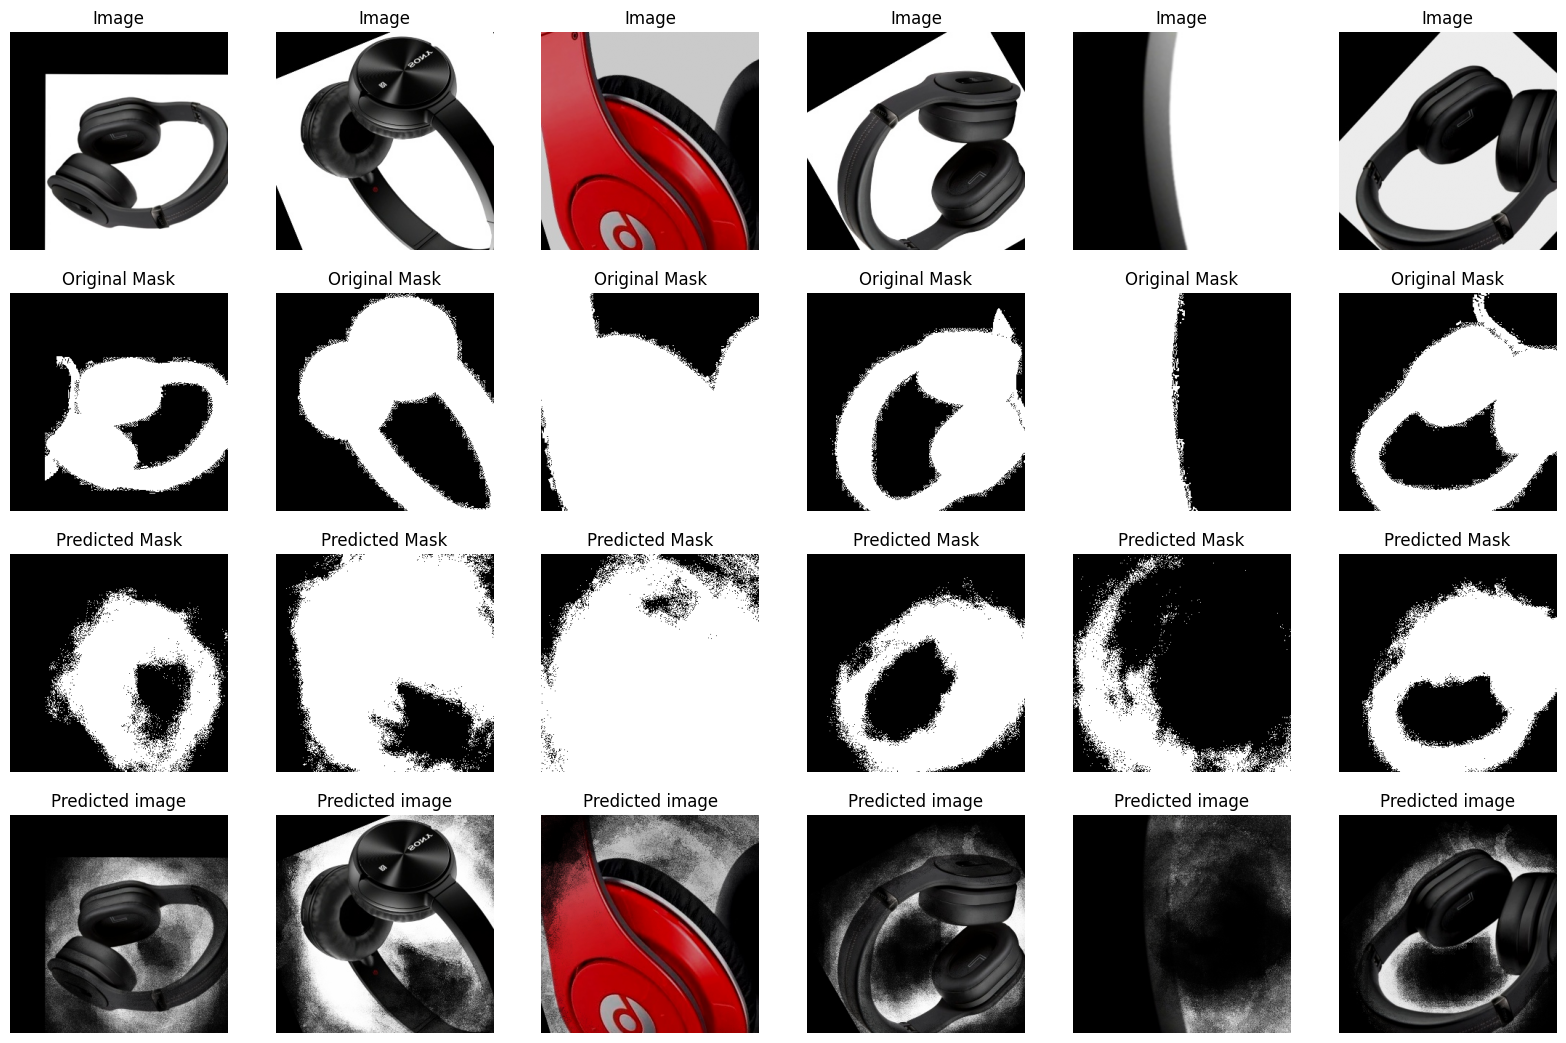

In [20]:
plot_results(x_v, y_v, model.predict(x_v), 2 * 3)

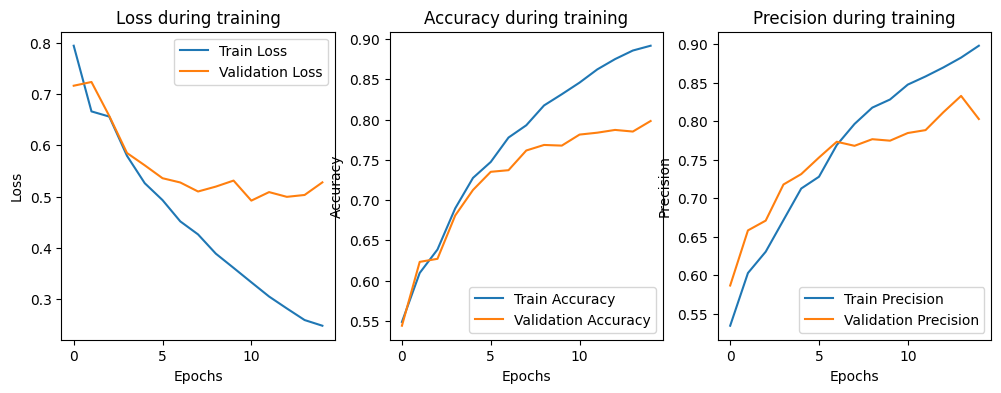

In [21]:
plot_hist(hst)

## U-net

2. **U-net** - Архитектура нейросети, созданная для сегментации изображений
Состоит из кодировщика и декодировщика
    1. *Кодировщик* - Состоит из свёрточных слоёв, позволяющих искать нужные признаки.
    2. *Декодировщик* - Состоит из транспонированных свёрточных слоёв, разворачивающих изображение и уменьшающих кол-во фильтров.

In [22]:
from tensorflow.keras.layers import *

In [24]:
inputs = Input(shape=(mass_img[0].shape))
# Кодировщик
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
# Декодировщик
u2 = UpSampling2D((2, 2))(p1)
u2 = Concatenate()([u2, c1])
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
# Выходной слой
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c2)

# Создаем модель
model_u = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [25]:
# model_u1 = unet_model((size_img[:], 3))

In [26]:
# Компилируем модель
model_u.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])
# model_u1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

In [27]:
type(y_t)

numpy.ndarray

In [28]:
# hst_u1 = model_u1.fit(x_t, y_t, validation_data=(x_v, y_v), epochs=10, batch_size=32)

In [29]:
# Обучаем модель
hst_u = model_u.fit(x_t, y_t, validation_data=(x_v, y_v), epochs=20, batch_size=20)  # При batch_size=32 модель тренируется слишком долго

Epoch 1/20


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 17s/step - accuracy: 0.5768 - loss: 0.6489 - precision: 0.6142 - val_accuracy: 0.6655 - val_loss: 0.5504 - val_precision: 0.7693
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.6462 - loss: 0.5530 - precision: 0.6386 - val_accuracy: 0.8423 - val_loss: 0.4703 - val_precision: 0.7959
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 15s/step - accuracy: 0.7934 - loss: 0.4517 - precision: 0.7389 - val_accuracy: 0.8685 - val_loss: 0.3542 - val_precision: 0.9046
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 121s 15s/step - accuracy: 0.8643 - loss: 0.3644 - precision: 0.8941 - val_accuracy: 0.8802 - val_loss: 0.3576 - val_precision: 0.8846
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 119s 15s/step - accuracy: 0.8775 - loss: 0.3495 - precision: 0.8946 - val_accuracy: 0.8762 - val_loss: 0.3278 - val_precision: 0.9249
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 119s 15s/step - accuracy: 0.8638 - loss: 0.3422 - precision: 0.8601 - val_accuracy: 0.8585 - val_loss: 0.3477 - val_precision

In [30]:
# plot_results(x_v, y_v, model_u1.predict(x_v), 2 * 3)

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(32, 300, 300, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


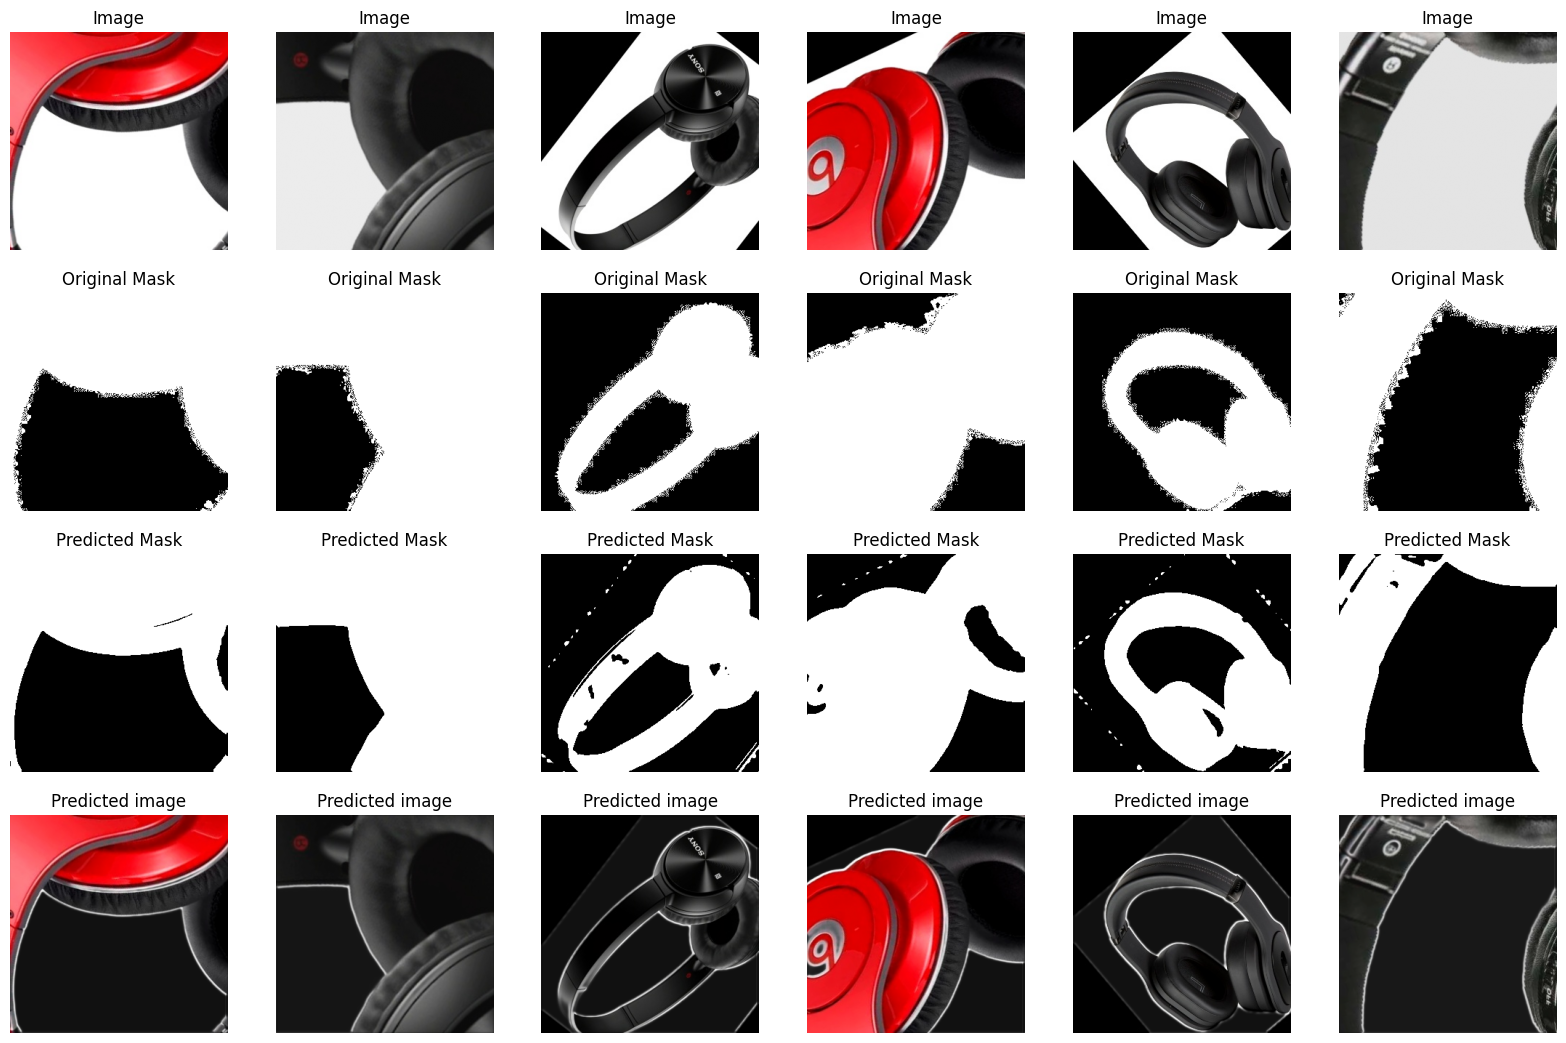

In [31]:
plot_results(x_v, y_v, model_u.predict(x_v), 2 * 3)

In [32]:
# plot_hist(hst_u1)

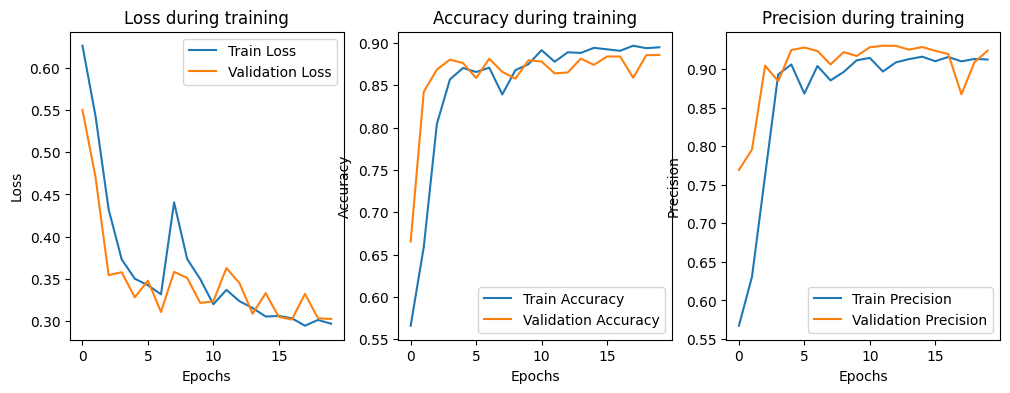

In [33]:
plot_hist(hst_u)